In [1]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

In [2]:
K_CRITICAL = 0.002

def estimate_fitness_B(B, params):
    """Estimates how approximate is 'B' to the maximum field
    that can be achieved by the geometry represented by 'params'
    """
    
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile
    
    B_low = 0.0

    B_high = B
    field_fraction = 0.35
    target_args = (B_high,B_low,field_fraction)


    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    K = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
    
    return K-K_CRITICAL



In [3]:
parameters = {"R_i": 0.030,
        "R_o": 0.19471,
        "h_fc": 0.025,
        "R_g": 209.75e-3,
        "R_s": 250e-3,
        "R_e": 0.7,
        "n_II": 5,
        "n_IV": 5,
        "phi_C_II": 0,
        "phi_S_II": 60,
        "phi_S_IV": 60,
        "mu_r_II": 1.05,
        "mu_r_IV": 1.05,
        "linear_iron": 1,
        "mu_r_iron": 5e2,
             }

n_II = parameters["n_II"]
n_IV = parameters["n_IV"]

n = n_II + n_IV

B_rem = 1.26

# expand parameters to include remanence magnitudes for each segment
parameters = teslamax.expand_parameters_from_remanence_array(B_rem*np.ones(n), 
                                                        parameters, 
                                                        "B_rem")

In [4]:
%%time

B_0 = 2.0

results = minimize(estimate_fitness_B,B_0,(parameters,),options={'disp':True})

         Current function value: 0.021953
         Iterations: 2
         Function evaluations: 68
         Gradient evaluations: 19
Wall time: 12h 30min 17s


In [5]:
results

      fun: 0.021953067564460124
 hess_inv: array([[1.92066876e-08]])
      jac: array([-15.03129569])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 68
      nit: 2
     njev: 19
   status: 2
  success: False
        x: array([0.98999795])

In [6]:
def optimize_ramp(B_high,field_fraction,params):
    """
    Run the TeslaMax optimization procedure, trying to match the profile
    to a ramp profile between 0 and 'B_high' with 'field_fraction', using the
    parameters in the dictionary 'params'.
    
    Return a TeslaMaxModel object, representing the optimized magnet,
    and the value of the cost function. The TeslaMaxModel object is already populated with simulation results.
    
    The simulation results are stored in directories inside "teslamax-play".
    """
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile
    
    B_low = 0.0
    
    target_args = (B_high,B_low,field_fraction)

    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    cost_function = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
    
    sdir = RAMP_RESULTS_DIR_FMT %(B_high*1e3, field_fraction*1e2) 
    
    teslamax_playground = str(TESLAMAX_PATH / PLAYGROUND_DIR / sdir )
    
    tmm_g = TeslaMaxModel(tmpd,
                          alpha_B_rem_g,
                          path=teslamax_playground)
    tmm_g.run()
    
    return (tmm_g,cost_function)
    

In [7]:
import nemplot
from nemplot import nemplot_parameters

In [8]:
nemplot.set_dpi(1500)
nemplot.set_fontsize(22)
nemplot.set_latex_font("Palatino")

In [9]:
def refine_list(original_list, factor):
    """
    Return a new list, inserting more elements between the number in 'original_list'.
    
    Assumes 'original_list' is evenly-spaced. The spacing between each element is divided by 'factor'
    
    >>>refine_list([1,2,3],factor=2)
    [1.0,1.5,2.0,2.5,3.0]
    """
    
    # calculate the original spacing between elements and refine it
    d = original_list[1] - original_list[0]
    d_refined = d / factor
        
    max_value = max(original_list)
    min_value = min(original_list)
    
    # the number of elements is the number of divisions between the limit values, plus one aditional
    n_refined = ((max_value - min_value) / d_refined) + 1
        
    return np.linspace(min_value,max_value,int(n_refined))

In [10]:
def plot_optimized_ramp(B_high,field_fraction):
    """
    Plot a comparison between the magnetic profile from the TeslaMax simulations
    and a ramp profile between 0 and 'B_high', with 'field_fraction'. The TeslaMax
    results are read from the appropriate files inside PLAYGROUND_DIR.
    
    Save the figure with the appropriate naming inside the 'figures' directory.
    """
 

    sdir = RAMP_RESULTS_DIR_FMT %(B_high*1e3, field_fraction*1e2) 
    
    teslamax_playground = TESLAMAX_PATH / PLAYGROUND_DIR / sdir
    
    profile_file = teslamax_playground / teslamax.MAGNETIC_PROFILE_FILENAME
    
    profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
    
    phi_vector_g, B_vector_g = teslamax.read_comsol_profile_data(str(profile_file))
    
    lw = 2.0
    profile_axes_g.plot(phi_vector_g,B_vector_g,linewidth=lw)
    profile_axes_g.set_xlim(0,np.max(phi_vector_g))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_g),9))
    profile_axes_g.grid(True)
    profile_axes_g.set_ylim(0,B_HIGH_LIMIT)
    
    ticks = profile_axes_g.get_yticks()
    profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)
        
    #profile_axes_g.set_yticks(np.arange(0,B_HIGH_LIMIT+0.2,0.2),minor=True)
    
    B_low = 0.0
    B_inst_vector = teslamax.calculate_ramp_profile(phi_vector_g,B_high,B_low,field_fraction)
    profile_axes_g.plot(phi_vector_g,B_inst_vector,'--',linewidth=lw)

    nemplot.save_figure(profile_fig_g,"profile_optimized_B_%d_FM_%d" %(B_high*1000,field_fraction*100))

In [11]:
results.x

array([0.98999795])

In [14]:
%%time
TESLAMAX_PATH = Path('.')

PLAYGROUND_DIR = "teslamax-play"
RAMP_RESULTS_DIR_FMT = "ramp_Bh_%d_FM_%d"

B_high = results.x[0]
field_fraction = 0.35

tmm_g_2, K_2 = optimize_ramp(B_high,field_fraction,parameters)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.023954275497772494
Wall time: 10min 58s


NameError: name 'B_HIGH_LIMIT' is not defined

C:\Users\fabiofortkamp\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


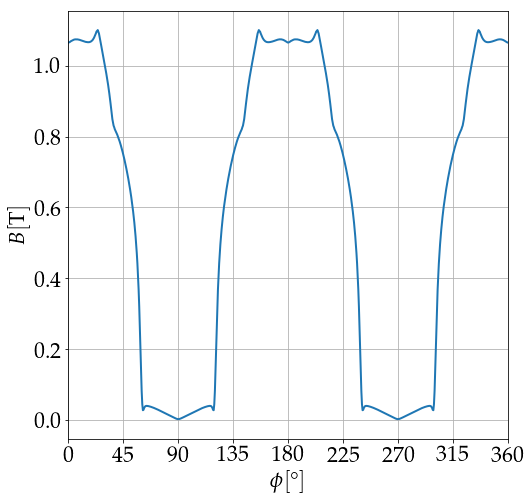

In [15]:
%matplotlib inline

plot_optimized_ramp(B_high,field_fraction)